<a href="https://colab.research.google.com/github/AriesMS/arki/blob/main/GROUNDINGDINO_FINETUNE_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!nvidia-smi
!python -V


%rm -rf /content/Open-GroundingDino
%mkdir -p /content/data/cmp


Tue Sep  9 08:02:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Install the library
!pip install anthropic

# Import and set up
import anthropic
from google.colab import userdata
import os

# Get API key from secrets
api_key = userdata.get('ANTHROPIC_API_KEY')
client = anthropic.Anthropic(api_key=api_key)

In [ ]:
# clone
!git clone https://github.com/longzw1997/Open-GroundingDino.git /content/Open-GroundingDino
%cd /content/Open-GroundingDino


Cloning into '/content/Open-GroundingDino'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 214 (delta 51), reused 42 (delta 36), pack-reused 107 (from 2)
Receiving objects: 100% (214/214), 11.96 MiB | 25.58 MiB/s, done.
Resolving deltas: 100% (72/72), done.
/content/Open-GroundingDino


In [ ]:
# install python deps
!pip -q install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.3/242.3 kB 20.9 MB/s eta 0:00:00


In [ ]:

# build CUDA ops used by GroundingDINO
%cd models/GroundingDINO/ops
!python setup.py build install
!python test.py
%cd ../../..


/content/Open-GroundingDino/models/GroundingDINO/ops
running build
running build_py
creating build/lib.linux-x86_64-cpython-312/modules
copying modules/ms_deform_attn.py -> build/lib.linux-x86_64-cpython-312/modules
copying modules/__init__.py -> build/lib.linux-x86_64-cpython-312/modules
creating build/lib.linux-x86_64-cpython-312/functions
copying functions/ms_deform_attn_func.py -> build/lib.linux-x86_64-cpython-312/functions
copying functions/__init__.py -> build/lib.linux-x86_64-cpython-312/functions
running build_ext
W0909 07:33:24.960000 804 torch/utils/cpp_extension.py:615] Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
W0909 07:33:25.002000 804 torch/utils/cpp_extension.py:507] The detected CUDA version (12.5) has a minor version mismatch with the version that was used to compile PyTorch (12.6). Most likely this shouldn't be a problem.
W0909 07:33:25.003000 804 torch/utils/cpp_extension.py:51

In [ ]:
# weights folder
%mkdir -p /content/weights

# download the commonly used Swin-T OGC checkpoint
!wget -q https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swint_ogc.pth \
     -O /content/weights/groundingdino_swint_ogc.pth

In [ ]:
import torch, subprocess, sys
print("torch:", torch.__version__, "cuda build:", torch.version.cuda)
print("cuda.is_available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))
print(subprocess.getoutput("nvidia-smi | head -n 20"))


torch: 2.8.0+cu126 cuda build: 12.6
cuda.is_available: True
device: NVIDIA A100-SXM4-40GB
Tue Sep  9 07:39:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |       

In [ ]:
# cache BERT weights (used as text encoder)
%%writefile cache_bert.py
from transformers import AutoTokenizer, AutoModel
AutoTokenizer.from_pretrained("bert-base-uncased")
AutoModel.from_pretrained("bert-base-uncased")
print("BERT cached.")

!python cache_bert.py

Writing cache_bert.py


In [ ]:
%cd /content/data/cmp
!wget -q https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip -O base.zip
!wget -q https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip -O ext.zip
!unzip -q base.zip
!unzip -q ext.zip
!ls -lah


/content/data/cmp
replace label_names.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
total 55M
drwxr-xr-x 4 root root 4.0K Sep  9 07:39 .
drwxr-xr-x 3 root root 4.0K Sep  9 07:33 ..
drwxr-xr-x 2 root root  36K Aug  1  2013 base
-rw-r--r-- 1 root root  35M Sep 16  2013 base.zip
drwxr-xr-x 2 root root  28K Sep 16  2013 extended
-rw-r--r-- 1 root root  20M Sep 16  2013 ext.zip
-rw-r--r-- 1 root root  136 Sep 16  2013 label_names.txt
-rw-r--r-- 1 root root 1.3K Sep 16  2013 readme.txt


In [ ]:
# Check the structure of the extracted dataset
!ls -R /content/data/cmp

/content/data/cmp:
base  base.zip	extended  ext.zip  label_names.txt  readme.txt

/content/data/cmp/base:
cmp_b0001.jpg  cmp_b0076.xml  cmp_b0152.png  cmp_b0228.jpg  cmp_b0303.xml
cmp_b0001.png  cmp_b0077.jpg  cmp_b0152.xml  cmp_b0228.png  cmp_b0304.jpg
cmp_b0001.xml  cmp_b0077.png  cmp_b0153.jpg  cmp_b0228.xml  cmp_b0304.png
cmp_b0002.jpg  cmp_b0077.xml  cmp_b0153.png  cmp_b0229.jpg  cmp_b0304.xml
cmp_b0002.png  cmp_b0078.jpg  cmp_b0153.xml  cmp_b0229.png  cmp_b0305.jpg
cmp_b0002.xml  cmp_b0078.png  cmp_b0154.jpg  cmp_b0229.xml  cmp_b0305.png
cmp_b0003.jpg  cmp_b0078.xml  cmp_b0154.png  cmp_b0230.jpg  cmp_b0305.xml
cmp_b0003.png  cmp_b0079.jpg  cmp_b0154.xml  cmp_b0230.png  cmp_b0306.jpg
cmp_b0003.xml  cmp_b0079.png  cmp_b0155.jpg  cmp_b0230.xml  cmp_b0306.png
cmp_b0004.jpg  cmp_b0079.xml  cmp_b0155.png  cmp_b0231.jpg  cmp_b0306.xml
cmp_b0004.png  cmp_b0080.jpg  cmp_b0155.xml  cmp_b0231.png  cmp_b0307.jpg
cmp_b0004.xml  cmp_b0080.png  cmp_b0156.jpg  cmp_b0231.xml  cmp_b0307.png
cmp_b0

In [ ]:
!find /content/data/cmp -type f -name "*.jpg" | wc -l
!find /content/data/cmp -type f -name "*.xml" | wc -l
!find /content/data/cmp -maxdepth 3 -type f | sort | head -60


606
606
/content/data/cmp/base/cmp_b0001.jpg
/content/data/cmp/base/cmp_b0001.png
/content/data/cmp/base/cmp_b0001.xml
/content/data/cmp/base/cmp_b0002.jpg
/content/data/cmp/base/cmp_b0002.png
/content/data/cmp/base/cmp_b0002.xml
/content/data/cmp/base/cmp_b0003.jpg
/content/data/cmp/base/cmp_b0003.png
/content/data/cmp/base/cmp_b0003.xml
/content/data/cmp/base/cmp_b0004.jpg
/content/data/cmp/base/cmp_b0004.png
/content/data/cmp/base/cmp_b0004.xml
/content/data/cmp/base/cmp_b0005.jpg
/content/data/cmp/base/cmp_b0005.png
/content/data/cmp/base/cmp_b0005.xml
/content/data/cmp/base/cmp_b0006.jpg
/content/data/cmp/base/cmp_b0006.png
/content/data/cmp/base/cmp_b0006.xml
/content/data/cmp/base/cmp_b0007.jpg
/content/data/cmp/base/cmp_b0007.png
/content/data/cmp/base/cmp_b0007.xml
/content/data/cmp/base/cmp_b0008.jpg
/content/data/cmp/base/cmp_b0008.png
/content/data/cmp/base/cmp_b0008.xml
/content/data/cmp/base/cmp_b0009.jpg
/content/data/cmp/base/cmp_b0009.png
/content/data/cmp/base/cmp_b00

In [ ]:
import os, glob, json, shutil, random
from PIL import Image
import lxml.etree as ET
from sklearn.model_selection import train_test_split
from tqdm import tqdm

IMG_ROOT  = "/content/data/cmp"
COCO_ROOT = "/content/data/cmp_coco"
os.makedirs(f"{COCO_ROOT}/images", exist_ok=True)

CMP_CLASSES = ["facade","molding","cornice","pillar","window","door",
               "sill","blind","balcony","shop","deco","background"]
cat_id = {n:i+1 for i,n in enumerate(CMP_CLASSES)}  # COCO cat ids 1..12

In [ ]:
def coco_skel():
    return {"images":[], "annotations":[],
            "categories":[{"id":i+1,"name":n} for i,n in enumerate(CMP_CLASSES)]}

def collect_img_annot_pairs(root_dir):
    imgs = sorted(glob.glob(os.path.join(root_dir, "**", "*.jpg"), recursive=True))
    pairs=[]
    for img in imgs:
        stem = os.path.splitext(os.path.basename(img))[0]
        for cand in [
            os.path.join(os.path.dirname(img), stem + ".xml"),
            os.path.join(os.path.dirname(os.path.dirname(img)), "annotations", stem + ".xml"),
        ]:
            if os.path.exists(cand):
                pairs.append((img, cand)); break
    return pairs

In [ ]:
# ------- fragment-safe parser -------

def find_ci(node, tag):  # case-insensitive
    xp = ".//*[translate(local-name(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ','abcdefghijklmnopqrstuvwxyz')=$t]"
    return node.xpath(xp, t=tag.lower())

def parse_fragment_xml(text, W, H):
    """
    CMP files often contain multiple <object> blocks with no root.
    We wrap them so the XML is well-formed, then parse.
    Returns: list of (labelname, [x,y,w,h]) in pixels.
    """
    wrapped = f"<root>\n{text}\n</root>"
    root = ET.fromstring(wrapped.encode("utf-8"))
    out = []
    for obj in find_ci(root, "object"):
        pts = find_ci(obj, "points")
        if not pts:
            continue
        xs = [float(x.text) for x in find_ci(pts[0], "x") if x.text]
        ys = [float(y.text) for y in find_ci(pts[0], "y") if y.text]
        if len(xs) < 2 or len(ys) < 2:
            continue
        x1, x2 = sorted([xs[0]*W, xs[1]*W])
        y1, y2 = sorted([ys[0]*H, ys[1]*H])
        w, h = max(0.0, x2-x1), max(0.0, y2-y1)
        if w <= 1 or h <= 1:
            continue
        ln = find_ci(obj, "labelname")
        if not ln or not (ln[0].text or "").strip():
            continue
        name = ln[0].text.strip().lower()
        out.append((name, [float(x1), float(y1), float(w), float(h)]))
    return out


In [ ]:
def build_coco(pairs, out_json):
    coco, ann_id, img_id = coco_skel(), 1, 1
    zero_obj_files = 0
    for img_path, annot_path in tqdm(pairs):
        new_name = f"{img_id:06d}.jpg"
        dst = os.path.join(COCO_ROOT, "images", new_name)
        if not os.path.exists(dst):
            shutil.copy(img_path, dst)

        W, H = Image.open(img_path).size
        coco["images"].append({"id": img_id, "file_name": new_name, "width": W, "height": H})

        text = open(annot_path, "r", encoding="utf-8", errors="ignore").read()
        objs = parse_fragment_xml(text, W, H)
        if not objs:
            zero_obj_files += 1

        for name, bbox in objs:
            if name not in cat_id:
                continue
            coco["annotations"].append({
                "id": ann_id, "image_id": img_id, "category_id": cat_id[name],
                "bbox": bbox, "area": float(bbox[2]*bbox[3]), "iscrowd": 0
            })
            ann_id += 1

        img_id += 1

    with open(out_json, "w") as f:
        json.dump(coco, f)
    print(f"Wrote {out_json} — {len(coco['images'])} images, {len(coco['annotations'])} boxes. "
          f"Files with 0 parsed objects: {zero_obj_files}")

In [ ]:
# === Paths & class list ===
import os, glob, json, shutil, random
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn.model_selection import train_test_split

IMG_ROOT   = "/content/data/cmp"          # where you unzipped base/ and extended/
COCO_ROOT  = "/content/data/cmp_coco"     # unified output
os.makedirs(f"{COCO_ROOT}/images", exist_ok=True)

# CMP class list (ordered as in the dataset’s documentation)
CMP_CLASSES = [
    "facade","molding","cornice","pillar","window","door",
    "sill","blind","balcony","shop","deco"
]
# COCO-style ids (1..12)
cat_id = {n:i+1 for i,n in enumerate(CMP_CLASSES)}

def coco_skel():
    return {
        "images": [],
        "annotations": [],
        "categories": [{"id": i+1, "name": n} for i,n in enumerate(CMP_CLASSES)]
    }


In [ ]:
def collect_img_annot_pairs(root_dir):
    imgs = sorted(glob.glob(os.path.join(root_dir, "**", "*.jpg"), recursive=True))
    pairs = []
    for img in imgs:
        stem = os.path.splitext(os.path.basename(img))[0]
        for cand in [
            os.path.join(os.path.dirname(img), stem + ".xml"),
            os.path.join(os.path.dirname(os.path.dirname(img)), "annotations", stem + ".xml"),
        ]:
            if os.path.exists(cand):
                pairs.append((img, cand))
                break
    return pairs

def _find_case_ins(node, tag):
    # case-insensitive findall for both lxml-ish and stdlib ElementTree
    xp = ".//*[translate(local-name(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ','abcdefghijklmnopqrstuvwxyz')=$t]"
    return node.findall(xp, namespaces=None) if False else [
        e for e in node.iter() if e.tag.lower()==tag.lower()
    ]

import xml.etree.ElementTree as ET

def _xml_text(el, name_candidates):
    for n in name_candidates:
        v = el.findtext(f".//{n}")
        if v is not None:
            return v
    return None

def parse_fragment_xml(xml_text, W_show, H_show):
    """
    Build tight bboxes from polygon vertices in CMP XML.
    Handles: normalized [0..1], pixel, and 0..1000 scales.
    Rescales from annotation image size -> displayed JPEG size (W_show,H_show).
    Returns: list of (labelname_lower, [x,y,w,h]) in *pixels* of the JPEG.
    """
    # 1) wrap+parse
    root = ET.fromstring(f"<root>{xml_text}</root>".encode("utf-8"))

    # 2) read annotation's own image size if present
    annW = None; annH = None
    # common tag names seen across forks
    for candW in ["imagewidth","imgwidth","width","imgWidth","ImageWidth"]:
        s = _xml_text(root, [candW])
        if s and s.strip().isdigit():
            annW = int(float(s))
            break
    for candH in ["imageheight","imgheight","height","imgHeight","ImageHeight"]:
        s = _xml_text(root, [candH])
        if s and s.strip().isdigit():
            annH = int(float(s))
            break
    # Fallback to the JPEG size if the XML doesn't store one
    if annW is None: annW = W_show
    if annH is None: annH = H_show

    # 3) iterate objects
    out = []
    for obj in [e for e in root if isinstance(e.tag,str) and e.tag.lower()=="object"]:
        # label
        name_elem = next((e for e in obj if isinstance(e.tag,str) and e.tag.lower()=="labelname"), None)
        if name_elem is None or not (name_elem.text or "").strip():
            continue
        name = name_elem.text.strip().lower()

        # points block
        pts_el = next((e for e in obj if isinstance(e.tag,str) and e.tag.lower()=="points"), None)
        if pts_el is None:
            continue

        # Prefer paired <point><x/><y/></point>
        pts = []
        for p in pts_el.findall(".//point"):
            xs = _xml_text(p, ["x","X"])
            ys = _xml_text(p, ["y","Y"])
            if xs is None or ys is None:
                continue
            try:
                pts.append((float(xs), float(ys)))
            except:
                pass

        # If no <point> pairs, try parallel <x> and <y> lists and zip them
        if not pts:
            xs = [float(e.text) for e in pts_el.findall(".//x") if e.text]
            ys = [float(e.text) for e in pts_el.findall(".//y") if e.text]
            if len(xs) and len(xs)==len(ys):
                pts = list(zip(xs, ys))

        if len(pts) < 2:
            continue

        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]

        # 4) detect coordinate scale in the XML
        maxx, maxy = max(xs), max(ys)
        # normalized?
        if maxx <= 1.5 and maxy <= 1.5:
            xs_pix = [x * annW for x in xs]
            ys_pix = [y * annH for y in ys]
        # 0..1000-ish?
        elif maxx <= 1100 and maxy <= 1100 and (annW > 1100 or annH > 1100):
            sx = annW / 1000.0
            sy = annH / 1000.0
            xs_pix = [x * sx for x in xs]
            ys_pix = [y * sy for y in ys]
        else:
            # assume already pixels in the XML's image size
            xs_pix, ys_pix = xs, ys

        # 5) some rare files use bottom-left origin; autodetect & flip if needed
        # Heuristic: if many ys are near annH (bottom) on objects that should be near top,
        # we can't know semantics here; use a safer geometry test:
        if min(ys_pix) < -5 or max(ys_pix) > annH + 5:
            # wildly out-of-bounds -> try flipping Y
            ys_pix = [annH - y for y in ys_pix]

        # 6) bbox in annotation space
        x1, x2 = max(0.0, min(xs_pix)), min(annW - 1.0, max(xs_pix))
        y1, y2 = max(0.0, min(ys_pix)), min(annH - 1.0, max(ys_pix))
        w, h = x2 - x1, y2 - y1
        if w < 1 or h < 1:
            continue

        # 7) rescale from annotation image size to the actual JPEG's size
        sx = W_show / float(annW)
        sy = H_show / float(annH)
        x1_s, y1_s = x1 * sx, y1 * sy
        w_s,  h_s  = w  * sx, h  * sy

        # 8) clamp
        x1_s = float(max(0.0, min(W_show-1.0, x1_s)))
        y1_s = float(max(0.0, min(H_show-1.0, y1_s)))
        w_s  = float(max(1.0, min(W_show - x1_s, w_s)))
        h_s  = float(max(1.0, min(H_show - y1_s, h_s)))

        out.append((name, [x1_s, y1_s, w_s, h_s]))

    return out


In [ ]:
def build_coco(pairs, out_json):
    coco, ann_id, img_id = coco_skel(), 1, 1
    zero_obj_files = 0

    for img_path, annot_path in tqdm(pairs, desc=f"COCO({os.path.basename(out_json)})"):
        new_name = f"{img_id:06d}.jpg"
        dst = os.path.join(COCO_ROOT, "images", new_name)
        if not os.path.exists(dst):
            shutil.copy(img_path, dst)

        W, H = Image.open(img_path).size
        coco["images"].append({"id": img_id, "file_name": new_name, "width": W, "height": H})

        text = open(annot_path, "r", encoding="utf-8", errors="ignore").read()
        objs = parse_fragment_xml(text, W, H)
        if not objs:
            zero_obj_files += 1

        for name, bbox in objs:
            if name not in cat_id:
                continue
            coco["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": cat_id[name],  # 1..12
                "bbox": bbox,
                "area": float(bbox[2]*bbox[3]),
                "iscrowd": 0
            })
            ann_id += 1
        img_id += 1

    with open(out_json, "w") as f:
        json.dump(coco, f)
    print(f"Wrote {out_json} — {len(coco['images'])} images, {len(coco['annotations'])} boxes. "
          f"Files with 0 parsed objects: {zero_obj_files}")

# ---- run it ----
all_pairs = collect_img_annot_pairs(IMG_ROOT)
print("Total image+xml pairs:", len(all_pairs))

# 80/20 split that matches CMP ~484/122 if 606 total
train_pairs, val_pairs = train_test_split(all_pairs, test_size=0.2, random_state=42)
os.makedirs(COCO_ROOT, exist_ok=True)
build_coco(train_pairs, os.path.join(COCO_ROOT, "cmp_train.json"))
build_coco(val_pairs,   os.path.join(COCO_ROOT, "cmp_val.json"))
print("Images live in:", os.path.join(COCO_ROOT,"images"))


Total image+xml pairs: 606


COCO(cmp_train.json): 100%|██████████| 484/484 [00:01<00:00, 383.25it/s]


Wrote /content/data/cmp_coco/cmp_train.json — 484 images, 41476 boxes. Files with 0 parsed objects: 0


COCO(cmp_val.json): 100%|██████████| 122/122 [00:00<00:00, 285.86it/s]


Wrote /content/data/cmp_coco/cmp_val.json — 122 images, 10286 boxes. Files with 0 parsed objects: 0
Images live in: /content/data/cmp_coco/images


In [ ]:
import json, time

val_path = "/content/data/cmp_coco/cmp_val.json"

with open(val_path, "r") as f:
    coco = json.load(f)

# Add minimal COCO-required top-level keys if missing
coco.setdefault("info", {
    "description": "CMP COCO-style validation set",
    "version": "1.0",
    "year": 2025,
    "date_created": time.strftime("%Y-%m-%d")
})
coco.setdefault("licenses", [])  # empty is fine

# (Optional) tidy up
coco["images"] = sorted({im["id"]: im for im in coco["images"]}.values(), key=lambda x: int(x["id"]))
coco["annotations"] = sorted(coco["annotations"], key=lambda x: (int(x["image_id"]), int(x["id"])))
coco["categories"] = sorted(coco["categories"], key=lambda x: int(x["id"]))

with open(val_path, "w") as f:
    json.dump(coco, f)

print("Patched:", val_path, "— added 'info'/'licenses' if missing.")


Patched: /content/data/cmp_coco/cmp_val.json — added 'info'/'licenses' if missing.


Per-class counts: {1: 548, 5: 16167, 6: 495, 3: 3295, 9: 1497, 8: 3475, 11: 3201, 2: 1401, 4: 5756, 10: 1391, 7: 4250}


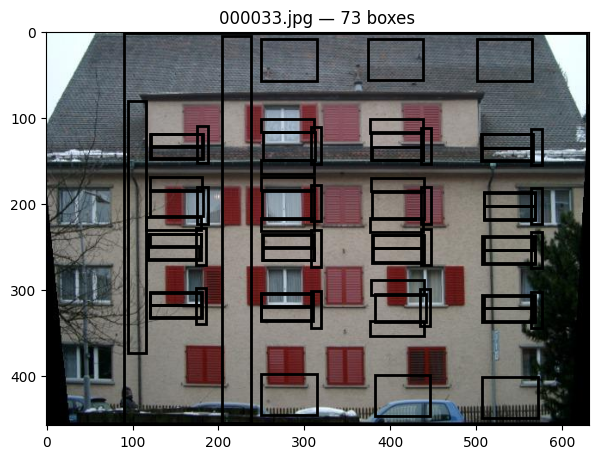

In [ ]:
import matplotlib.pyplot as plt, matplotlib.patches as patches
import collections, random
coco = json.load(open(f"{COCO_ROOT}/cmp_train.json"))
cnt = collections.Counter([a["category_id"] for a in coco["annotations"]])
print("Per-class counts:", dict(cnt))

def show(idx=0):
    im = coco["images"][idx]
    anns = [a for a in coco["annotations"] if a["image_id"]==im["id"]]
    img = Image.open(os.path.join(COCO_ROOT,"images", im["file_name"])).convert("RGB")
    fig, ax = plt.subplots(figsize=(7,7)); ax.imshow(img)
    for a in anns[:200]:  # cap to avoid clutter
        x,y,w,h = a["bbox"]
        ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, linewidth=2))
    ax.set_title(f"{im['file_name']} — {len(anns)} boxes"); plt.show()

show(32)


In [ ]:
import os, glob
from collections import defaultdict
from PIL import Image
import xml.etree.ElementTree as ET
root = "/content/data/cmp"

# index images and xmls by stem
def stem(p): return os.path.splitext(os.path.basename(p))[0]
imgs = sorted(glob.glob(os.path.join(root, "**", "*.jpg"), recursive=True))
xmls = sorted(glob.glob(os.path.join(root, "**", "*.xml"), recursive=True))
img_by_stem = defaultdict(list); [img_by_stem[stem(p)].append(p) for p in imgs]
xml_by_stem = defaultdict(list); [xml_by_stem[stem(p)].append(p) for p in xmls]

print("images:", len(imgs), "unique stems:", len(img_by_stem))
print("xmls:", len(xmls), "unique stems:", len(xml_by_stem))

# 1) spot missing/duplicate basenames (common pairing bugs)
missing_xml = [s for s in img_by_stem if s not in xml_by_stem]
missing_img = [s for s in xml_by_stem if s not in img_by_stem]
multi_img  = {s:ps for s,ps in img_by_stem.items() if len(ps)>1}
multi_xml  = {s:ps for s,ps in xml_by_stem.items() if len(ps)>1}
print("images without xml:", len(missing_xml), missing_xml[:10])
print("xml without images:", len(missing_img), missing_img[:10])
print("stems with >1 images:", len(multi_img))
print("stems with >1 xmls:", len(multi_xml))

# 2) robust resolver: prefer XML from the same split folder (base vs extended)
def find_xml_for_image(img_path):
    s = stem(img_path)
    cands = xml_by_stem.get(s, [])
    if not cands: return None
    parts = img_path.split(os.sep)
    for split in ("CMP_facade_DB_base","base","CMP_facade_DB_extended","extended"):
        if split in parts:
            for c in cands:
                if split in c.split(os.sep):
                    return c
    # climb to nearest 'annotations' sibling if present
    d = os.path.dirname(img_path)
    while True:
        ann = os.path.join(d, "annotations", s + ".xml")
        if os.path.exists(ann): return ann
        d2 = os.path.dirname(d)
        if d2 == d: break
        d = d2
    return cands[0]  # last fallback

# 3) sanity: check XML coordinate scale & overlay bounds for a few random pairs
import random
def xml_xy_ranges(xml_path):
    t = open(xml_path, "r", encoding="utf-8", errors="ignore").read()
    root_xml = ET.fromstring(f"<root>{t}</root>".encode("utf-8"))
    xs, ys = [], []
    for obj in root_xml.findall(".//object"):
        pts = obj.find("./points")
        if pts is None: continue
        xs += [float(e.text) for e in pts.findall(".//x") if e.text]
        ys += [float(e.text) for e in pts.findall(".//y") if e.text]
    return (min(xs, default=None), max(xs, default=None)), (min(ys, default=None), max(ys, default=None))

for img_path in random.sample(imgs, min(5, len(imgs))):
    xml_path = find_xml_for_image(img_path)
    W,H = Image.open(img_path).size
    (xmin, xmax), (ymin, ymax) = xml_xy_ranges(xml_path)
    print(os.path.basename(img_path), (W,H), "->", os.path.basename(xml_path),
          "| x:[", xmin, ",", xmax, "] y:[", ymin, ",", ymax, "]")
    if xmax and (xmax>1.5 or ymax>1.5):
        print("  NOTE: this XML uses pixel/0..1000 coords; convert by the XML's own image size.")
    else:
        print("  OK: normalized coords; scale by (W,H) of THIS JPEG.")


images: 606 unique stems: 606
xmls: 606 unique stems: 606
images without xml: 0 []
xml without images: 0 []
stems with >1 images: 0
stems with >1 xmls: 0
cmp_x0057.jpg (1024, 639) -> cmp_x0057.xml | x:[ 0.0031299 , 1.0 ] y:[ 0.00097656 , 1.0 ]
  OK: normalized coords; scale by (W,H) of THIS JPEG.
cmp_b0319.jpg (452, 610) -> cmp_b0319.xml | x:[ 0.057377 , 1.0 ] y:[ 0.050885 , 0.99779 ]
  OK: normalized coords; scale by (W,H) of THIS JPEG.
cmp_x0093.jpg (653, 1024) -> cmp_x0093.xml | x:[ 0.00097656 , 0.99512 ] y:[ 0.029096 , 0.99847 ]
  OK: normalized coords; scale by (W,H) of THIS JPEG.
cmp_b0019.jpg (1024, 889) -> cmp_b0019.xml | x:[ 0.0033746 , 0.99775 ] y:[ 0.00097656 , 0.99902 ]
  OK: normalized coords; scale by (W,H) of THIS JPEG.
cmp_b0358.jpg (487, 454) -> cmp_b0358.xml | x:[ 0.011013 , 0.9978 ] y:[ 0.036961 , 1.0 ]
  OK: normalized coords; scale by (W,H) of THIS JPEG.


Convert COCO train to ODVG

In [ ]:
# Rebuild /content/data/cmp_coco/cmp_train_odvg.jsonl in the ODVG format
import json, os
from collections import defaultdict

coco_train = "/content/data/cmp_coco/cmp_train.json"
odvg_out   = "/content/data/cmp_coco/cmp_train_odvg.jsonl"

with open(coco_train, "r") as f:
    coco = json.load(f)

# image meta
img_meta = {im["id"]: {"file_name": im["file_name"], "width": im["width"], "height": im["height"]}
            for im in coco["images"]}
# categories
cats = {c["id"]: c["name"] for c in coco["categories"]}

# collect instances per image (convert COCO xywh -> xyxy)
by_image = defaultdict(list)
for ann in coco["annotations"]:
    x, y, w, h = ann["bbox"]
    x2, y2 = x + w, y + h
    by_image[ann["image_id"]].append({
        "bbox": [float(x), float(y), float(x2), float(y2)],   # xyxy
        "label": int(ann["category_id"])-1,                     # keep same ids as in COCO
        "category": cats[int(ann["category_id"])]
    })

# write JSONL lines with required keys: filename, height, width, detection.instances
n_lines = 0
with open(odvg_out, "w") as out:
    for img_id, instances in by_image.items():
        m = img_meta[img_id]
        rec = {
            "filename": m["file_name"],  # just the filename (e.g., "000001.jpg")
            "height": int(m["height"]),
            "width": int(m["width"]),
            "detection": {"instances": instances}
        }
        out.write(json.dumps(rec) + "\n")
        n_lines += 1

print(f"✓ Wrote {odvg_out} with {n_lines} lines")
# quick sanity peek
with open(odvg_out) as f:
    for _ in range(3):
        print(f.readline().strip())


✓ Wrote /content/data/cmp_coco/cmp_train_odvg.jsonl with 484 lines
{"filename": "000001.jpg", "height": 1024, "width": 589, "detection": {"instances": [{"bbox": [2.3007518, 5.2156416, 587.85145, 1017.04704], "label": 0, "category": "facade"}, {"bbox": [100.6601, 850.14528, 169.10779, 930.11968], "label": 4, "category": "window"}, {"bbox": [101.80865, 93.881344, 170.25634, 173.85472], "label": 4, "category": "window"}, {"bbox": [101.23732, 340.75648, 167.38201999999998, 424.20224], "label": 4, "category": "window"}, {"bbox": [101.80865, 605.00992, 167.95924000000002, 684.98432], "label": 4, "category": "window"}, {"bbox": [185.21105, 93.881344, 258.26472, 173.85472], "label": 4, "category": "window"}, {"bbox": [182.91395, 850.14528, 255.96173000000002, 930.11968], "label": 4, "category": "window"}, {"bbox": [270.91643999999997, 846.67392, 351.44452, 930.11968], "label": 4, "category": "window"}, {"bbox": [272.64221000000003, 93.881344, 356.04461, 175.59552], "label": 4, "category": "win

In [ ]:
# Simple flat label_map: string id -> class name (derived from your COCO file)
import json

coco_train = "/content/data/cmp_coco/cmp_train.json"
with open(coco_train, "r") as f:
    coco = json.load(f)

cats = {str(i): name for i, name in enumerate(
    ["facade","molding","cornice","pillar","window","door","sill","blind","balcony","shop","deco"]
)}
label_map_path = "/content/data/cmp_coco/cmp_label_map.json"
with open(label_map_path, "w") as f:
    json.dump(cats, f, indent=2)

print("✓ label_map:", label_map_path)
print(cats)


✓ label_map: /content/data/cmp_coco/cmp_label_map.json
{'0': 'facade', '1': 'molding', '2': 'cornice', '3': 'pillar', '4': 'window', '5': 'door', '6': 'sill', '7': 'blind', '8': 'balcony', '9': 'shop', '10': 'deco'}


In [ ]:
datasets_cfg = {
  "train": [
    {"root": "/content/data/cmp_coco/images",
     "anno": "/content/data/cmp_coco/cmp_train_odvg.jsonl",
     "label_map": "/content/data/cmp_coco/cmp_label_map.json",
     "dataset_mode": "odvg"}
  ],
  "val": [
    {"root": "/content/data/cmp_coco/images",
     "anno": "/content/data/cmp_coco/cmp_val.json",
     "label_map": None,
     "dataset_mode": "coco"}
  ]
}
import json, os
os.makedirs("/content/Open-GroundingDino/config", exist_ok=True)
with open("/content/Open-GroundingDino/config/datasets_cmp_odvg.json","w") as f:
    json.dump(datasets_cfg, f, indent=2)


In [ ]:
# Verify the 3 critical fields exist on a sample line
import json, itertools
sample = next(itertools.islice(open("/content/data/cmp_coco/cmp_train_odvg.jsonl"), 0, 1))
obj = json.loads(sample)
assert "filename" in obj and "detection" in obj and "instances" in obj["detection"], "ODVG schema wrong"
assert isinstance(obj["detection"]["instances"], list) and len(obj["detection"]["instances"])>0, "No instances?"
print("✓ ODVG schema looks good:", obj["filename"], "instances:", len(obj["detection"]["instances"]))


✓ ODVG schema looks good: 000001.jpg instances: 141


In [ ]:
%cd /content/Open-GroundingDino
import re, pathlib
cfg_path = "config/cfg_odvg.py"
t = pathlib.Path(cfg_path).read_text(encoding="utf-8")

def set_kv(src, key, pyvalue):
    pat = rf"^\s*{re.escape(key)}\s*=.*$"
    repl = f"{key} = {pyvalue}"
    return re.sub(pat, repl, src, flags=re.M) if re.search(pat, src, flags=re.M) else src + f"\n{repl}\n"

# 11 classes, no background
t = set_kv(t, "label_list",
           '["facade","molding","cornice","pillar","window","door","sill","blind","balcony","shop","deco"]')

# turn off COCO mapping for custom eval
t = set_kv(t, "use_coco_eval", "False")

# keep text encoder here (some forks read it from cfg)
t = set_kv(t, "bert_name", "'bert-base-uncased'")
t = set_kv(t, "text_encoder_type", "'bert-base-uncased'")  # harmless if unused

# remove args-only keys if present
for k in ("output_dir","pretrain_model_path","pretrained_ckpt"):
    t = re.sub(rf"^\s*{k}\s*=.*\n", "", t, flags=re.M)

pathlib.Path(cfg_path).write_text(t, encoding="utf-8")
print("✓ cfg updated: 11-class label_list, use_coco_eval=False; args-only keys removed")



/content/Open-GroundingDino
✓ cfg updated: 11-class label_list, use_coco_eval=False; args-only keys removed


In [ ]:
%cd /content/Open-GroundingDino
import re, pathlib
cfg = pathlib.Path("config/cfg_odvg.py").read_text(encoding="utf-8")

def set_kv(src, key, value):
    pat = rf"^\s*{re.escape(key)}\s*=.*$"
    repl = f"{key} = {value}"
    return re.sub(pat, repl, src, flags=re.M) if re.search(pat, src, flags=re.M) else src + f"\n{repl}\n"

# Try common keys used across forks:
for k,v in [
    ("lr", "1e-4"),                  # global LR
    ("lr_backbone", "1e-5"),         # backbone LR
    ("text_encoder_lr", "2e-5"),     # BERT/text LR
    ("bert_learning_rate", "2e-5"),  # some forks use this name
]:
    cfg = set_kv(cfg, k, v)

pathlib.Path("config/cfg_odvg.py").write_text(cfg, encoding="utf-8")
print("✓ Updated LRs in cfg_odvg.py")


/content/Open-GroundingDino
✓ Updated LRs in cfg_odvg.py


In [ ]:
%cd /content/Open-GroundingDino
!python main.py \
  --config_file config/cfg_odvg.py \
  --datasets    config/datasets_cmp_odvg.json \
  --output_dir  /content/runs/cmp_swint \
  --pretrain_model_path /content/weights/groundingdino_swint_ogc.pth \
  --num_workers 2 \
  --device cuda



/content/Open-GroundingDino
Not using distributed mode
Loading config file from config/cfg_odvg.py
INFO     2025-09-08 08:24:31,266 | git:
  sha: d248268ac9cab808d4aa2691f4a76972ec5d9ab4, status: has uncommited changes, branch: main

INFO     2025-09-08 08:24:31,266 | Command: main.py --config_file config/cfg_odvg.py --datasets config/datasets_cmp_odvg.json --output_dir /content/runs/cmp_swint --pretrain_model_path /content/weights/groundingdino_swint_ogc.pth --num_workers 2 --device cuda
INFO     2025-09-08 08:24:31,267 | Full config saved to /content/runs/cmp_swint/config_args_all.json
INFO     2025-09-08 08:24:31,267 | world size: 1
INFO     2025-09-08 08:24:31,267 | rank: 0
INFO     2025-09-08 08:24:31,267 | local_rank: 0
INFO     2025-09-08 08:24:31,267 | args: Namespace(config_file='config/cfg_odvg.py', options=None, datasets='config/datasets_cmp_odvg.json', remove_difficult=False, fix_size=False, output_dir='/content/runs/cmp_swint', note='', device='cuda', seed=42, resume='', p